# Iceberg Classification Challenge <a class="tocSkip">
[**Courtney Ferguson Lee**](https://www.linkedin.com/in/courtneyfergusonlee/)

This notebook is my baseline entry into the ongoing [kaggle iceberg data contest](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge).

<img src='http://3.bp.blogspot.com/-5hkivJoJVwo/UZ6kJGhHSGI/AAAAAAAAAJA/JNDa5sygvdQ/s1600/JR+++iceberg+2.jpg'>

# Introduction

Is it a ship or is it an iceberg? This project processes synthetic-aperture radar images and uses machine learning to identify whether each image contains a ship or an iceberg. Sounds easy enough, right? Well, the images are not normal images:

<img src='https://raw.github.com/spacecadet84/iceberg_challenge/master/images/hh_image.png'>

Synthetic aperture radar (SAR) images are captured from a moving antenna emitting successive pulses of radio waves. Institutions mount these antenna on unmanned aerial reconnaissance vessels to surveil land areas. The images in this case study were collected from the Sentinel-1 satelite constillation, orbitting 600 kilometers above the earth. The Sentinel-1 is a side looking radar (SLAR), which means that the radar points in a direction perpendicular to the direction of flight (see diagram below).

<img src='https://www.navcen.uscg.gov/images/iip/pics/c130slar.jpg'>

The Sentinel-1 transmits and receives energy in two channels: a vertical channel and a horizontal channel. These separate channels will help when analyzing the images because different objects have different polarimetric scattering features. We will explore a variety of transformation techniques to better understand how ships and icebergs reflect light and use these insights to distinguish our images.

<img src='https://storage.googleapis.com/kaggle-media/competitions/statoil/lhYaHT0.png'>



# Load Modules

First, we'll load the necessary modules to allow for data manipulation, visualizations and machine learning.

In [1]:
# Data Manipulation
import pandas as pd
pd.options.display.max_columns = 25
import numpy as np
from IPython.display import display

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {"axes.grid": False})
import missingno as msno

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
#from xgboost import XGBClassifier

# Load Data

In [2]:
# test, train and submission files
test = pd.read_json('data/test.json')
test_df = pd.DataFrame(test)

train = pd.read_json('data/train.json')
train_df = pd.DataFrame(train)

submission_ex = pd.read_csv('data/sample_submission.csv')

# Data Structure

Let's explore the basic structure of the data, including its overall shape, the datatypes involved and the number of missing datapoints.

## Basic Structure

shape
info
describe

In [3]:
train_df.shape

(1604, 5)

It appears that there are no missing datapoints, but according to the [official problem statement](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/data), some of the incident angles are missing. We may have to manipulate our dataset a bit to identify them.

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 75.2+ KB


In [5]:
train_df.describe()

,is_iceberg
count,1604.000000
mean,0.469451
std,0.499222
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
train_df.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


It looks like pandas read the inc_angle as text. We'll have to convert that to a float.

In [7]:
train_df.replace('na', np.NaN, inplace=True)
train_df['inc_angle'] = pd.to_numeric(train_df['inc_angle'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1471 non-null float64
is_iceberg    1604 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 75.2+ KB


Ah, now we can see the culprit. The nonetype values were coded as na. After replacing them, we can see that there are 133 missing values.

## Missing Data

The bulk of the missing values appear to be at the end, with a few scattered throughout.

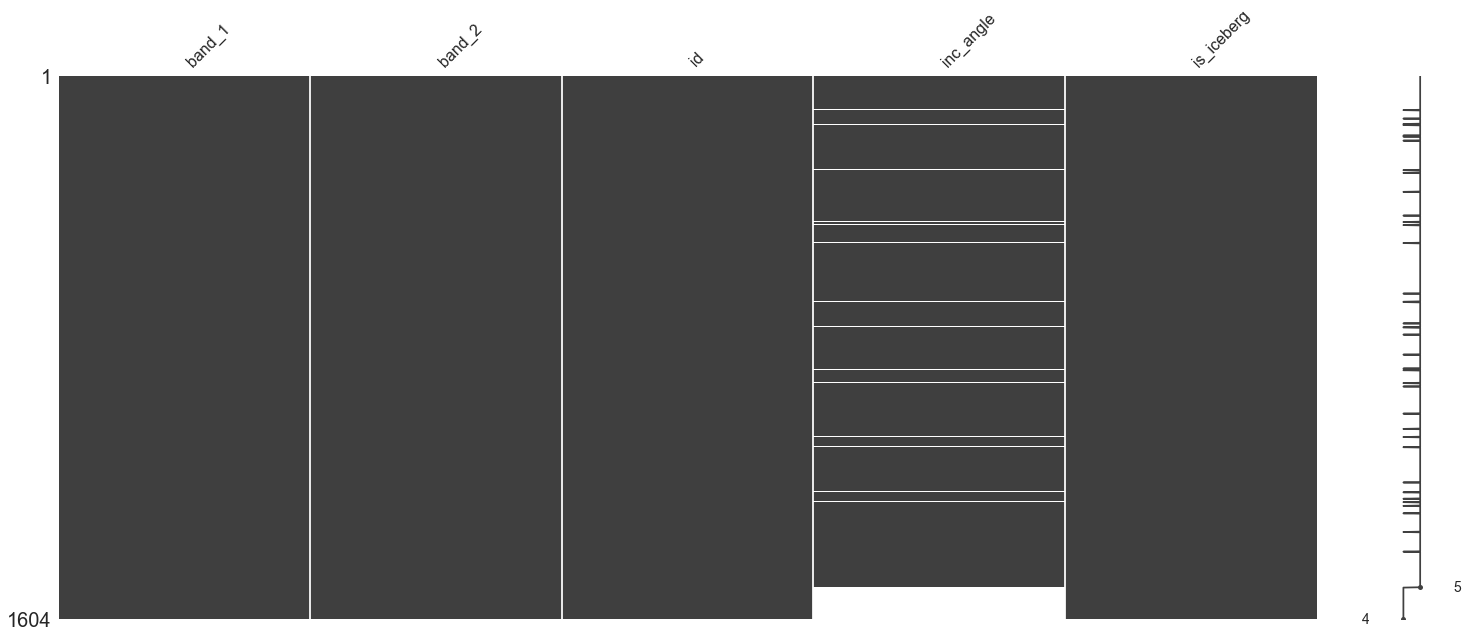

In [8]:
msno.matrix(train_df)

# Visualizations

Before modeling or engineering new features, let's visualize the data to gain a new perspective. We can see from the plot below that there are more ships than icebergs in our dataset. It's not extremely unbalanced, but it may warrant consideration when creating our models later.

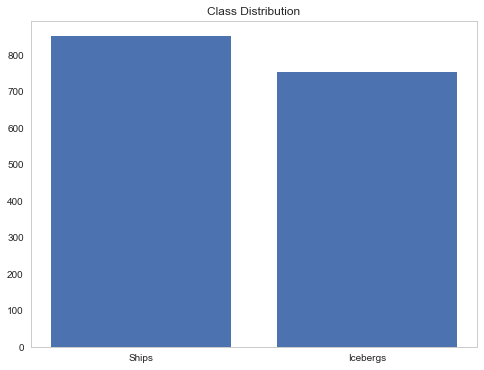

In [9]:
val_counts = train_df.is_iceberg.value_counts()
plt.figure(figsize=(8,6))
plt.bar(
    val_counts.index,
    val_counts.values
)
plt.xticks(range(2), ['Ships', 'Icebergs'])
plt.title('Class Distribution')
plt.show()

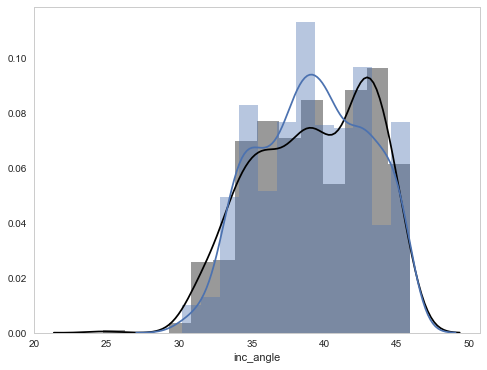

In [10]:
val_counts = train_df.inc_angle.value_counts()
plt.figure(figsize=(8,6))
sns.distplot(
    train_df[train_df.is_iceberg==False].inc_angle.dropna(),
    color='black'
)
sns.distplot(
    train_df[train_df.is_iceberg==True].inc_angle.dropna()
)

plt.show()

The above graph plots the distributions of the angle of incidence for icebergs and ships separately. We can see that although there is a lot of overlap, the peak for ships is approximately 44 degrees while the peak for icebergs is approximately 38 degrees.

Now that we uderstand the structure and distribution of our data, let's take a look at the images. In the example pics, the contrast between the hh and hv iceberg images is greater than the contrast between the hh and hv ship images. Icebergs seem to "disappear" under hv images, while ships are clearly visible in both hv and hh images. That difference in contrast may have some sort of significance.

In [11]:
band_1_ex = train_df.loc[0, 'band_1']
band_1_ex = np.array(band_1_ex)
band_1_square = band_1_ex.reshape(75, 75)

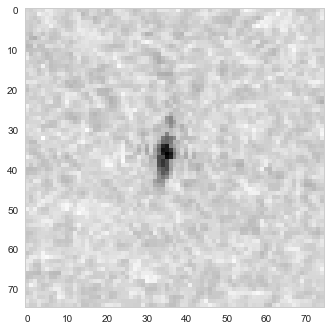

In [12]:
plt.imshow(band_1_square)
plt.show()

In [13]:
band_2_ex = train_df.loc[0, 'band_2']
band_2_ex = np.array(band_2_ex)
band_2_square = band_2_ex.reshape(75, 75)

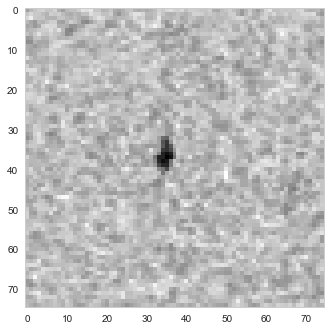

In [14]:
plt.imshow(band_2_square)
plt.show()

In [15]:
band_1_ex = train_df.loc[0, 'band_1']
band_2_ex = train_df.loc[0, 'band_2']
band_sub_1 = np.array(band_1_ex)
band_sub_2 = np.array(band_2_ex)
band_sub = band_sub_1 - band_sub_2
band_sub_square = band_sub.reshape(75, 75)

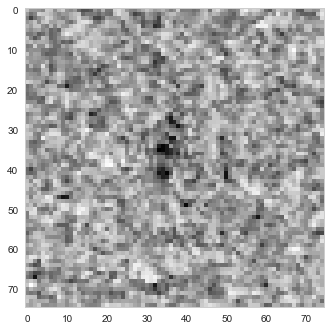

In [16]:
plt.imshow(band_sub_square)
plt.show()

In [17]:
def plot_image_grid(train, band_type, n_row, n_col):
    band = 'band_1'
    if 'HV' in band_type:
        band = 'band_2'
    classification = ''
    # Plot the first 8 eignenvalues
    plt.figure(figsize=(12,12))
    for i in list(range(n_row * n_col)):
    #     for offset in [10, 30,0]:
    #     plt.subplot(n_row, n_col, i + 1)
    #     offset =0
        sat_image = train.loc[i, band]
        sat_image = np.array(sat_image)
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(sat_image.reshape(75,75))
        
        if train.loc[i, 'is_iceberg']:
            classification = 'Iceberg'
        else:
            classification = 'Ship'
        title_text = "{0} {1:.0f} {2}".format(classification, train.loc[i, 'inc_angle'], '$^\circ$')
        plt.title(title_text, size=6.5)
        plt.xticks(())
        plt.yticks(())
    plt.suptitle(band_type)
    plt.show()


The individual plots were useful as a first-pass, but to better appreciate the distinguishing features of ship and iceberg images, we're going to need a lot more examples. The grids below show the horizontally and vertically polarized images of ships and icebergs. 

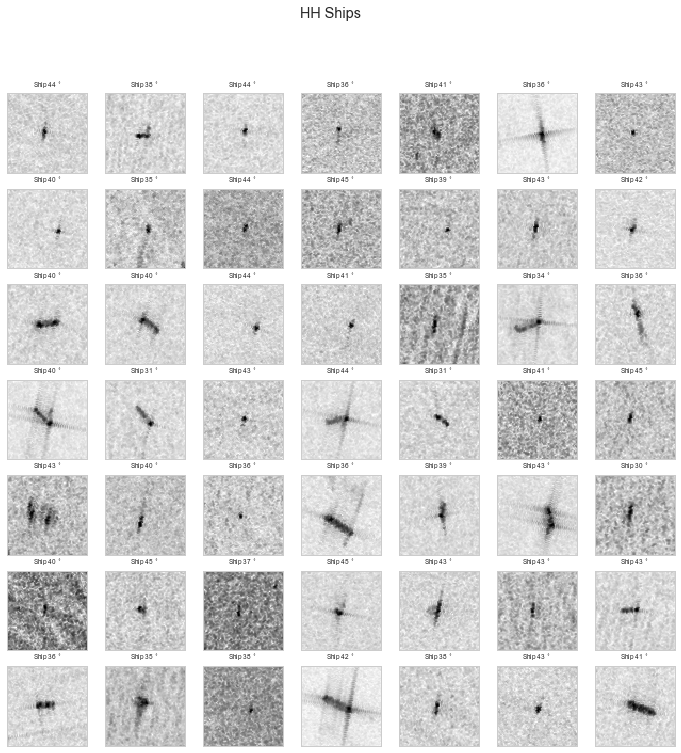

In [18]:
plot_image_grid(
    train_df[train_df.is_iceberg==0].reset_index(drop=True), 
    'HH Ships', 
    7, 
    7
)

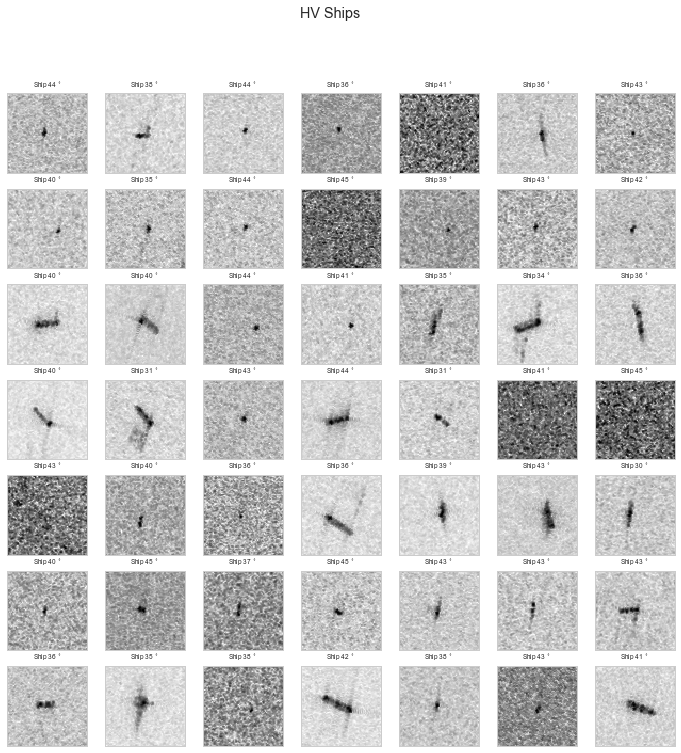

In [19]:
plot_image_grid(
    train_df[train_df.is_iceberg==0].reset_index(drop=True), 
    'HV Ships', 
    7, 
    7
)

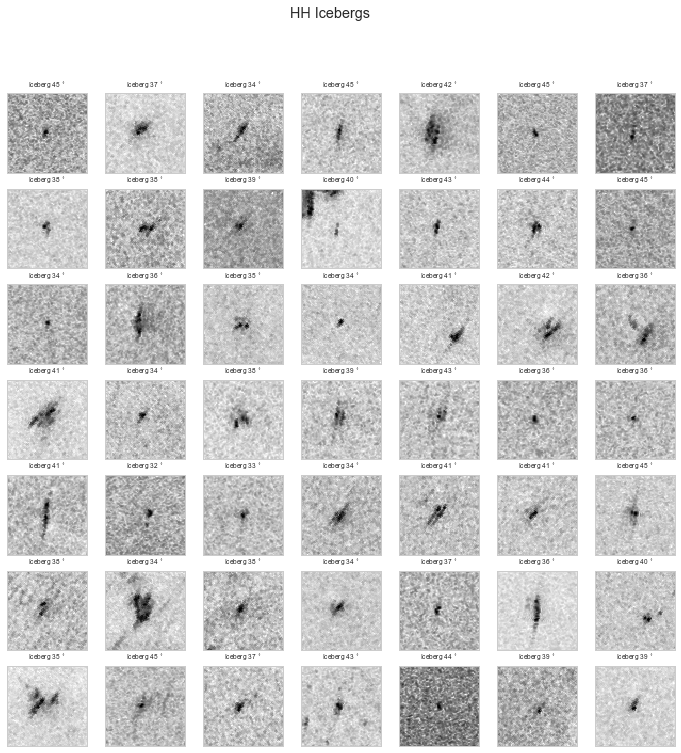

In [20]:
plot_image_grid(
    train_df[train_df.is_iceberg==1].reset_index(drop=True), 
    'HH Icebergs', 
    7, 
    7
)

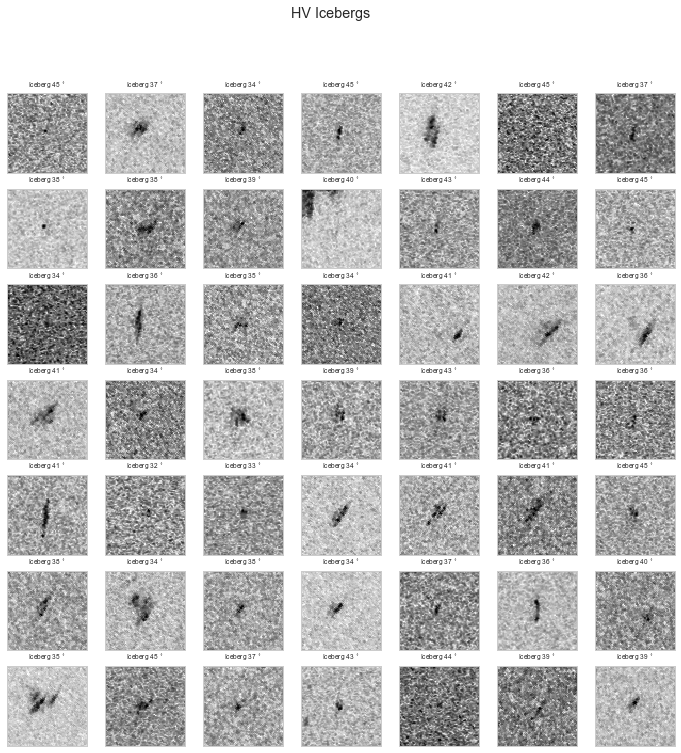

In [21]:
plot_image_grid(
    train_df[train_df.is_iceberg==1].reset_index(drop=True), 
    'HV Icebergs', 
    7, 
    7
)

# Feature Engineering

Need a way to feed the data from the two images into the classifier.

First thought: Subtract the two arrays and use the incidence angle as just another column.

- Turn each band cell into a numpy array
- The whole column can be a higher dimensional array
- Subtract the two arrays
- Turn the inc_angle column into a numpy array
- Concatenate the difference and inc_angle columns
- Feed into algorithm

Second thought: Take average of both images

- Repeat the process above, but average them using vector operations

In [22]:
band_1_arr = train_df.band_1.apply(np.asarray)
band_2_arr = train_df.band_2.apply(np.asarray)
band_diff = band_1_arr - band_2_arr
band_ave = (band_1_arr + band_2_arr)/2.0

band_ave_series = band_ave.apply(pd.Series)
band_diff_series = band_diff.apply(pd.Series)
band_1_df = band_1_arr.apply(pd.Series)
band_2_df = band_2_arr.apply(pd.Series)

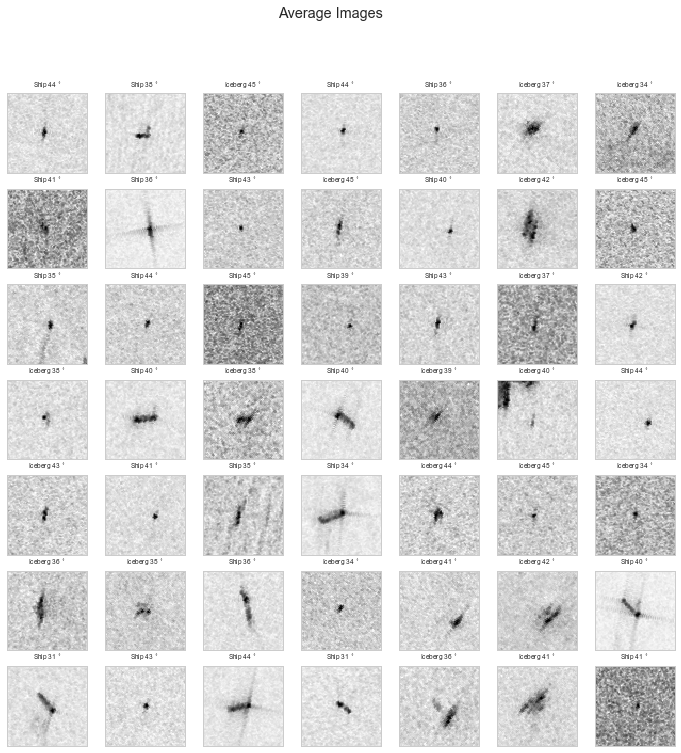

In [23]:
band_ave_df = train_df.copy()
band_ave_df.band_1 = band_ave
plot_image_grid(band_ave_df, 'Average Images', 7, 7)

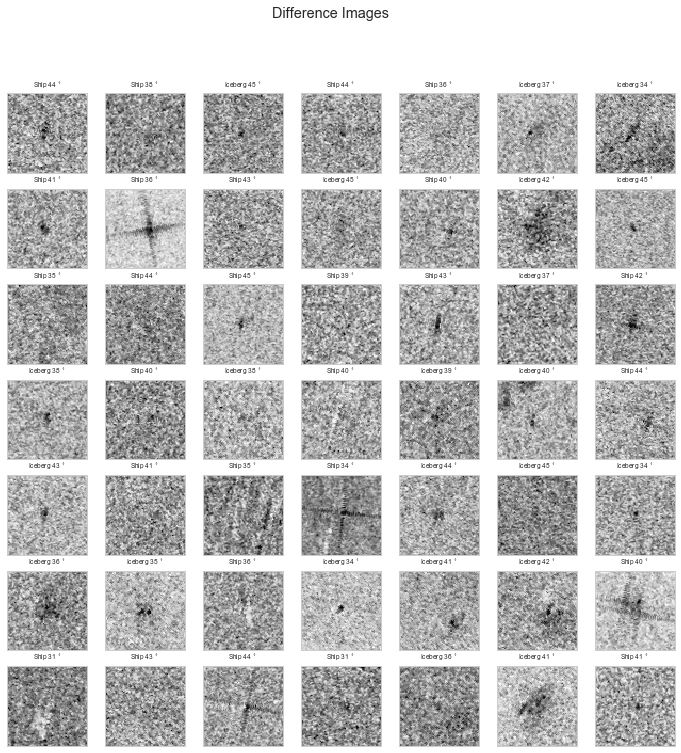

In [24]:
band_diff_df = train_df.copy()
band_diff_df.band_1 = band_diff
plot_image_grid(band_diff_df, 'Difference Images', 7, 7)

# Models

In our first pass, we'll compare a random forest classifier to logistic regression and submit the best results. We'll classify 4 different types of images:

- HH
- HV
- Differences
- Averages

After testing our random forest and logistic regression models on the horizontal data, we'll use the better-performing one for the remainder of our exploration. 

## HH Models

Our HH model had the best log loss, even though its accuracy was lower than the average model. Of course, the difference in accuracy was not significantly different between the models, so further analysis is needed. In the next iteration, I'll implement k-fold cross validation to make up for the higher variance of a train-test-split.

### Random Forests

In [25]:
hh_idea = pd.concat((band_1_df, train_df.inc_angle), axis=1)
forest = RandomForestClassifier(random_state=42)

x = hh_idea[hh_idea.inc_angle.isnull()==False].values
y = train_df.loc[train_df.inc_angle.isnull()==False, 'is_iceberg'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)
pred_prob = forest.predict_proba(x_test)
print "Log Loss:", log_loss(y_test, pred_prob, eps=1e-15)
print "Accuracy Score:", accuracy_score(y_test, pred)
print "Classification Report"
print classification_report(y_test, pred)
hh_conf_matrix = confusion_matrix(y_test, pred)

Log Loss: 0.636701384187
Accuracy Score: 0.717194570136
Classification Report
             precision    recall  f1-score   support

          0       0.69      0.75      0.72       211
          1       0.75      0.69      0.72       231

avg / total       0.72      0.72      0.72       442



### Logistic Regression

In [26]:
hh_idea = pd.concat((band_1_df, train_df.inc_angle), axis=1)
logreg = LogisticRegression(random_state=42)

x = hh_idea[hh_idea.inc_angle.isnull()==False].values
y = train_df.loc[train_df.inc_angle.isnull()==False, 'is_iceberg'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
logreg.fit(x_train, y_train)
pred = logreg.predict(x_test)
print "Accuracy Score:", accuracy_score(y_test, pred)
print "Classification Report"
print classification_report(y_test, pred)
hh_conf_matrix = confusion_matrix(y_test, pred)

Accuracy Score: 0.690045248869
Classification Report
             precision    recall  f1-score   support

          0       0.69      0.63      0.66       211
          1       0.69      0.75      0.72       231

avg / total       0.69      0.69      0.69       442



## HV Model

The random forests classifier outperformed logistic regression, so we'll stick with the former going forward. This is just a first pass, so we may return to the logistic model later, but for now, we're only interested in getting a benchmark.

In [27]:
hv_idea = pd.concat((band_2_df, train_df.inc_angle), axis=1)
forest = RandomForestClassifier(random_state=42)

x = hv_idea[hv_idea.inc_angle.isnull()==False].values
y = train_df.loc[train_df.inc_angle.isnull()==False, 'is_iceberg'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)
print "Classification Report"
print classification_report(y_test, pred)
hv_conf_matrix = confusion_matrix(y_test, pred)

Classification Report
             precision    recall  f1-score   support

          0       0.65      0.71      0.68       211
          1       0.71      0.65      0.68       231

avg / total       0.68      0.68      0.68       442



## Difference Model

This model performed poorly in both accuracy and log loss.

In [28]:
first_idea = pd.concat((band_diff_series, train_df.inc_angle), axis=1)
forest = RandomForestClassifier(random_state=42)

x = first_idea[first_idea.inc_angle.isnull()==False].values
y = train_df.loc[train_df.inc_angle.isnull()==False, 'is_iceberg'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)
print "Classification Report"
print classification_report(y_test, pred)
diff_conf_matrix = confusion_matrix(y_test, pred)

Classification Report
             precision    recall  f1-score   support

          0       0.59      0.70      0.64       211
          1       0.67      0.55      0.61       231

avg / total       0.63      0.62      0.62       442



## Average Model

Although this model had the best overall validation results, the log loss was worse here than in the HH model. Further investigation is needed before using this model to identify images in our test set.

In [29]:
average_idea = pd.concat((band_ave_series, train_df.inc_angle), axis=1)
forest = RandomForestClassifier(random_state=42)

x = average_idea[average_idea.inc_angle.isnull()==False].values
y = train_df.loc[train_df.inc_angle.isnull()==False, 'is_iceberg'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)
pred_prob = forest.predict_proba(x_test)
print "Log Loss:", log_loss(y_test, pred_prob, eps=1e-15)
print "Accuracy Score:", accuracy_score(y_test, pred)
print "Classification Report"
print classification_report(y_test, pred)
ave_conf_matrix = confusion_matrix(y_test, pred)

Log Loss: 0.659247172182
Accuracy Score: 0.753393665158
Classification Report
             precision    recall  f1-score   support

          0       0.71      0.82      0.76       211
          1       0.81      0.70      0.75       231

avg / total       0.76      0.75      0.75       442



In [30]:
def plot_conf_matrix(conf_matrix, title):
    conf_df = pd.DataFrame(conf_matrix)
    conf_df.columns = ['Ship', 'Iceberg']
    conf_df.index = ['Ship', 'Iceberg']
    
    sns.heatmap(
        conf_df,
        square=True,
        annot=True,
        cmap='viridis',
        fmt='0g'
    )
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.suptitle(title)
    plt.show()

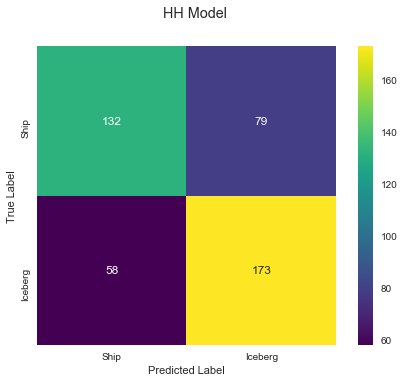

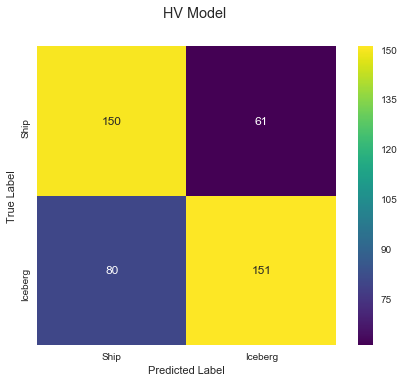

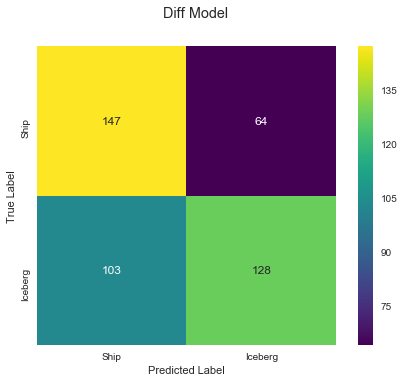

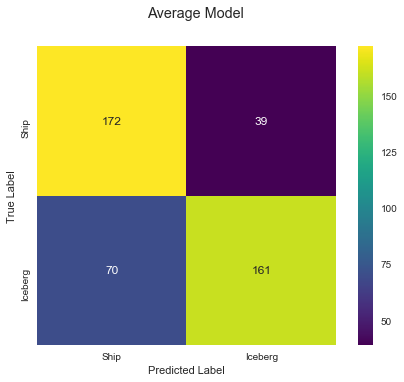

In [31]:
plot_conf_matrix(hh_conf_matrix, 'HH Model')
plot_conf_matrix(hv_conf_matrix, 'HV Model')
plot_conf_matrix(diff_conf_matrix, 'Diff Model')
plot_conf_matrix(ave_conf_matrix, 'Average Model')

# Submission 1 (HH Only)

Now that we have our trained classifier, we'll apply it to the test set and prepare our first submission.

Convert band_1 to its own dataframe

In [32]:
band_1_test_arr = test_df.band_1.apply(np.asarray)
band_1_test_df = band_1_test_arr.apply(pd.Series)

Extract inc_angle from test set and concat with band_1

In [33]:
hh_submission = pd.concat((band_1_test_df, test_df.inc_angle), axis=1)

Run predict_proba on array

In [34]:
x = hh_submission.values
pred = forest.predict(x)
pred_prob = forest.predict_proba(x)

Convert pred_prob to dataframe for submission

In [35]:
submission = pd.DataFrame(pred_prob)
submission.columns = ['not_iceberg', 'is_iceberg']

Extract the right column from each predict_proba row

In [36]:
submission = submission.is_iceberg
submission = pd.concat((test_df.id, submission), axis=1)

Check to make sure dataframe is formatted correctly

In [37]:
submission.head()

,id,is_iceberg
0,5941774d,0.7
1,4023181e,0.3
2,b20200e4,0.5
3,e7f018bb,0.7
4,4371c8c3,0.4


Convert to csv for submission

In [38]:
submission.to_csv('data/submission_v1.csv', index=False)

# Conclusions

This was a fun exploration into image recognition using SAR images. There is still a lot to explore here. We did not tune our hyperparameters and only tested out two models, but we were able to achieve 75% accuracy, which is pretty good for a bunch of fuzzy black and white images. There are still many unexplored feature engineering ideas:

1. Combine the two images
2. Extract the highest and lowest values from each hh and hv image
3. Use PCA for dimensionality reduction
4. Use fisher images for dimensionality reduction
5. Reduce noise in darker images
6. Apply a fourier transform or other transformation technique

I strongly suspect that the difference in polarization scattering is part of key to improving our accuracy, but I'm a little fuzzy on my physics and will need to review some calculus for the fourier transformation. Development on this project will continue over time as we use both domain knowledge and more advanced algorithms (convolutional neural nets) to improve our score. Thank you for taking a look at this analysis.